# From Prediction to Profit: 
# Cost-Sensitive Telecom Customer Churn Classification

In [425]:
# Import pakages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import math
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score


## 1. Data Checking

In [ ]:
df_raw = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df_raw.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [407]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [408]:
df = df_raw.copy()

In [409]:
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

In [410]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

## 2. Data preprocessing

In [411]:
# Change the type of 'SeniorCitizen' value
df['SeniorCitizen']=df['SeniorCitizen'].astype(object)

In [412]:
# Change the type of 'TotalCharges' value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop the unnessary column
df = df.drop('customerID', axis=1)

In [413]:
# Columns to apply the transformation
columns_to_update = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Replace 'No internet service' with 'No' in the specified columns
df[columns_to_update] = df[columns_to_update].replace('No internet service', 'No')

# Replace 'No phone service' with 'No' in the 'MultipleLines' column
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

In [414]:
# Check the categorical features
cat_cols=[col for col in df.columns if df[col].dtype=='object']
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [415]:
# Check the numerical features
num_cols=[col for col in df.columns if df[col].dtype !='object']
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

- Missing values

In [416]:
df['TotalCharges'].isna().sum()
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = (df['MonthlyCharges'] * df['tenure'])

## 3. EDA

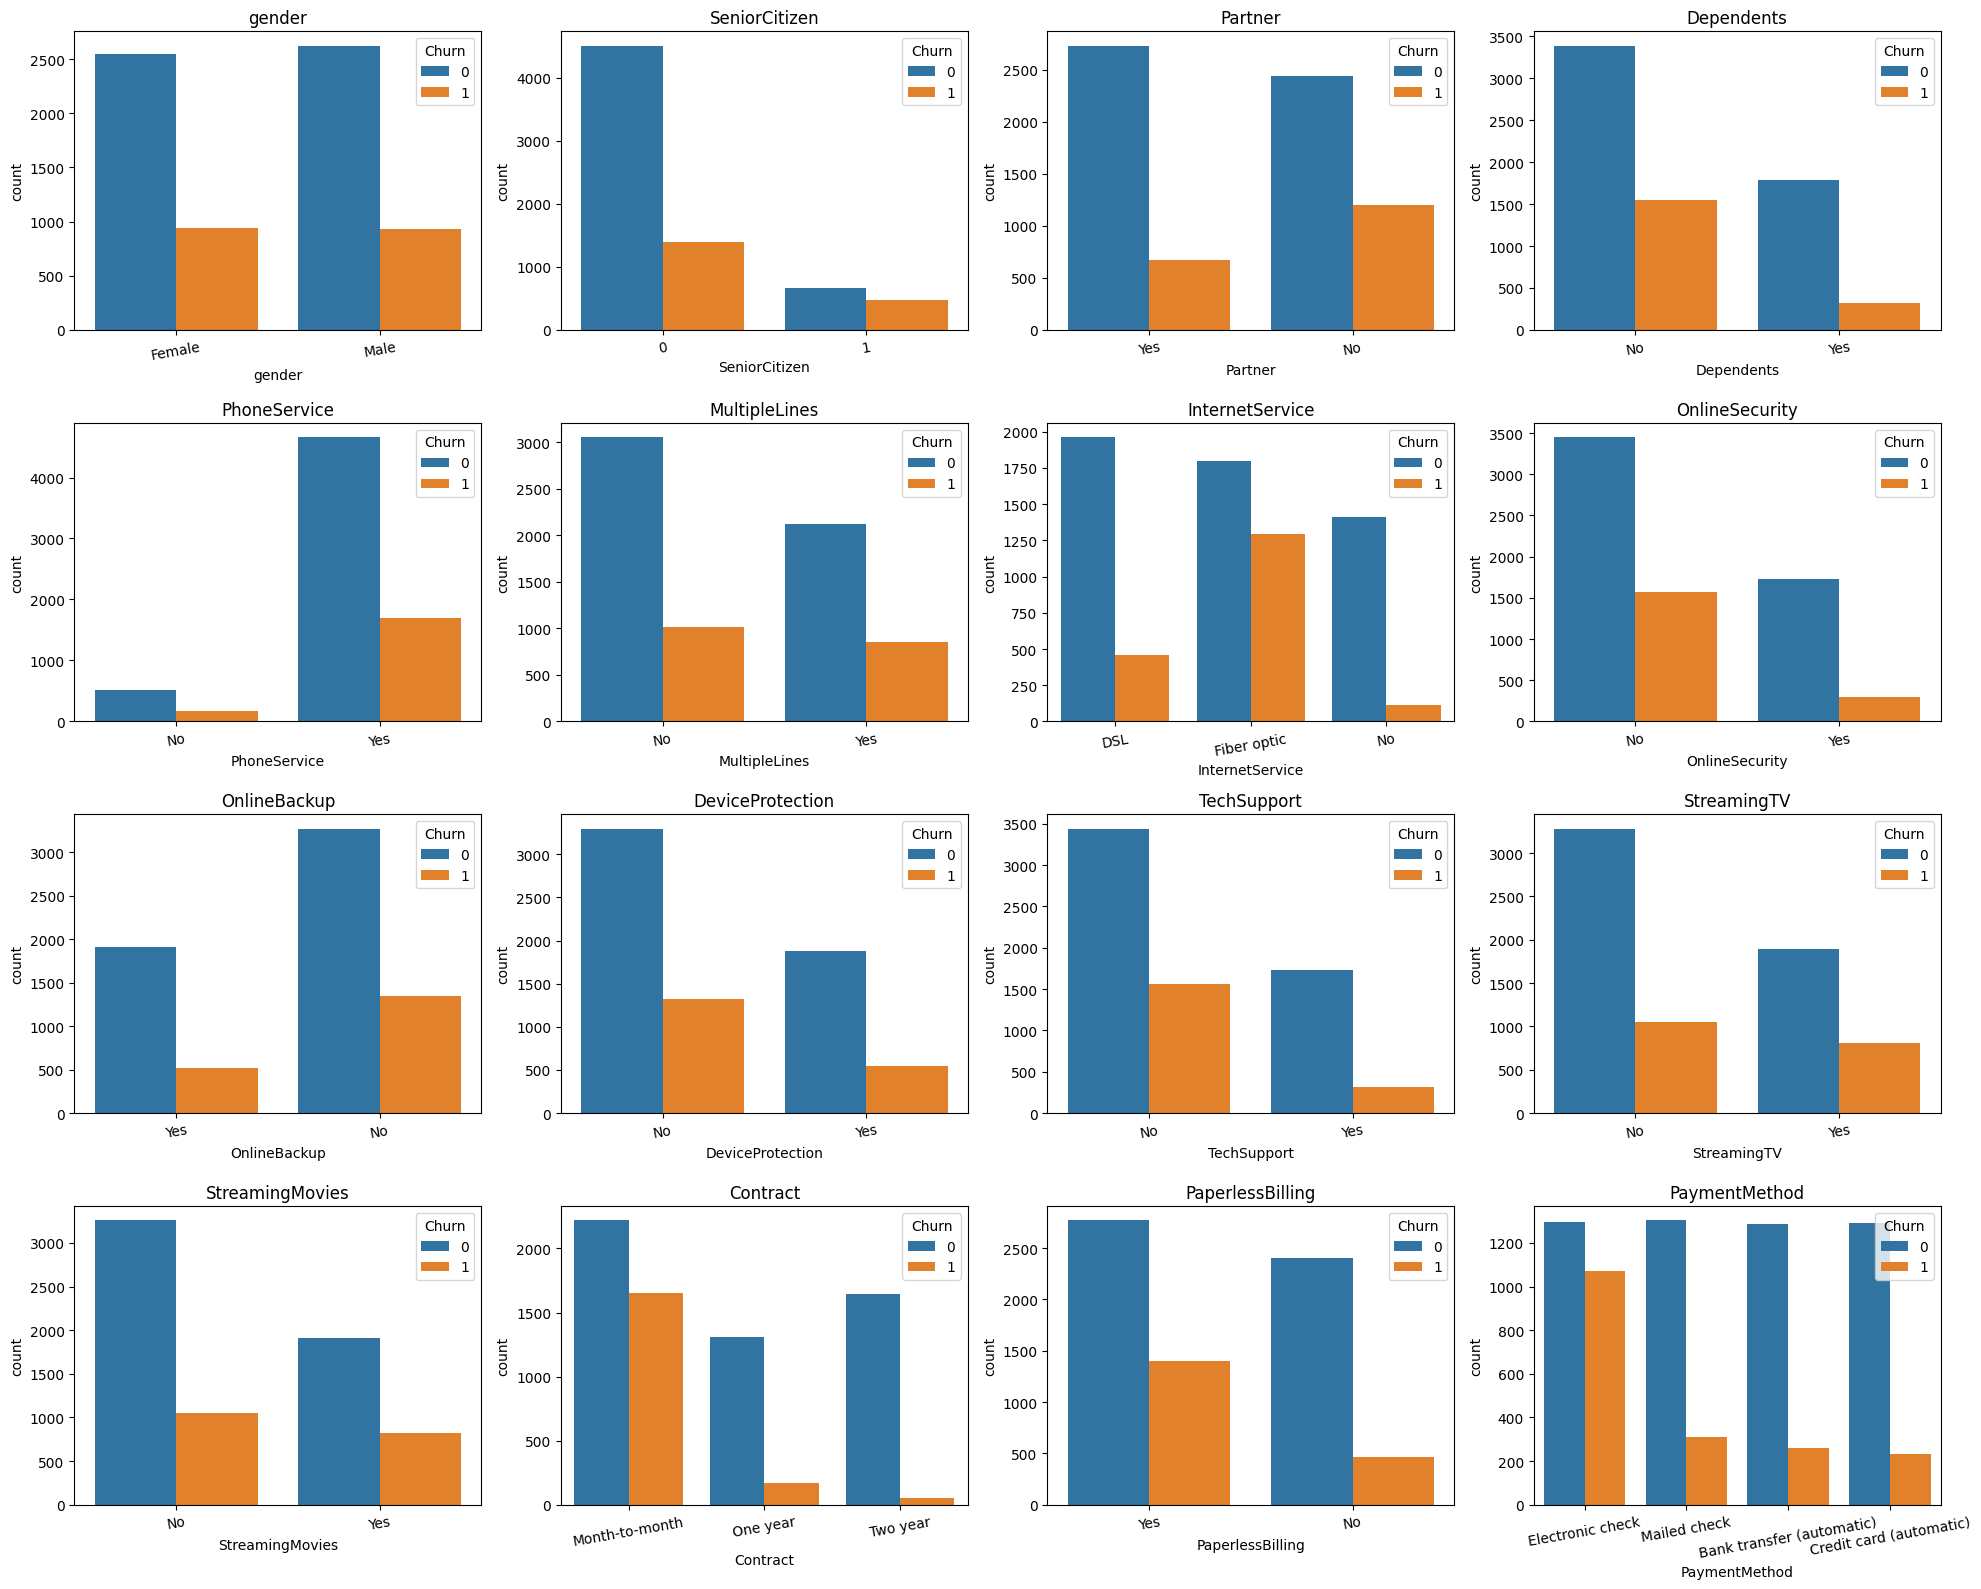

In [420]:
# Check the categorical values 
cat_cols

n_cols = 4 
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue="Churn", ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=10)

# Delete remaining subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

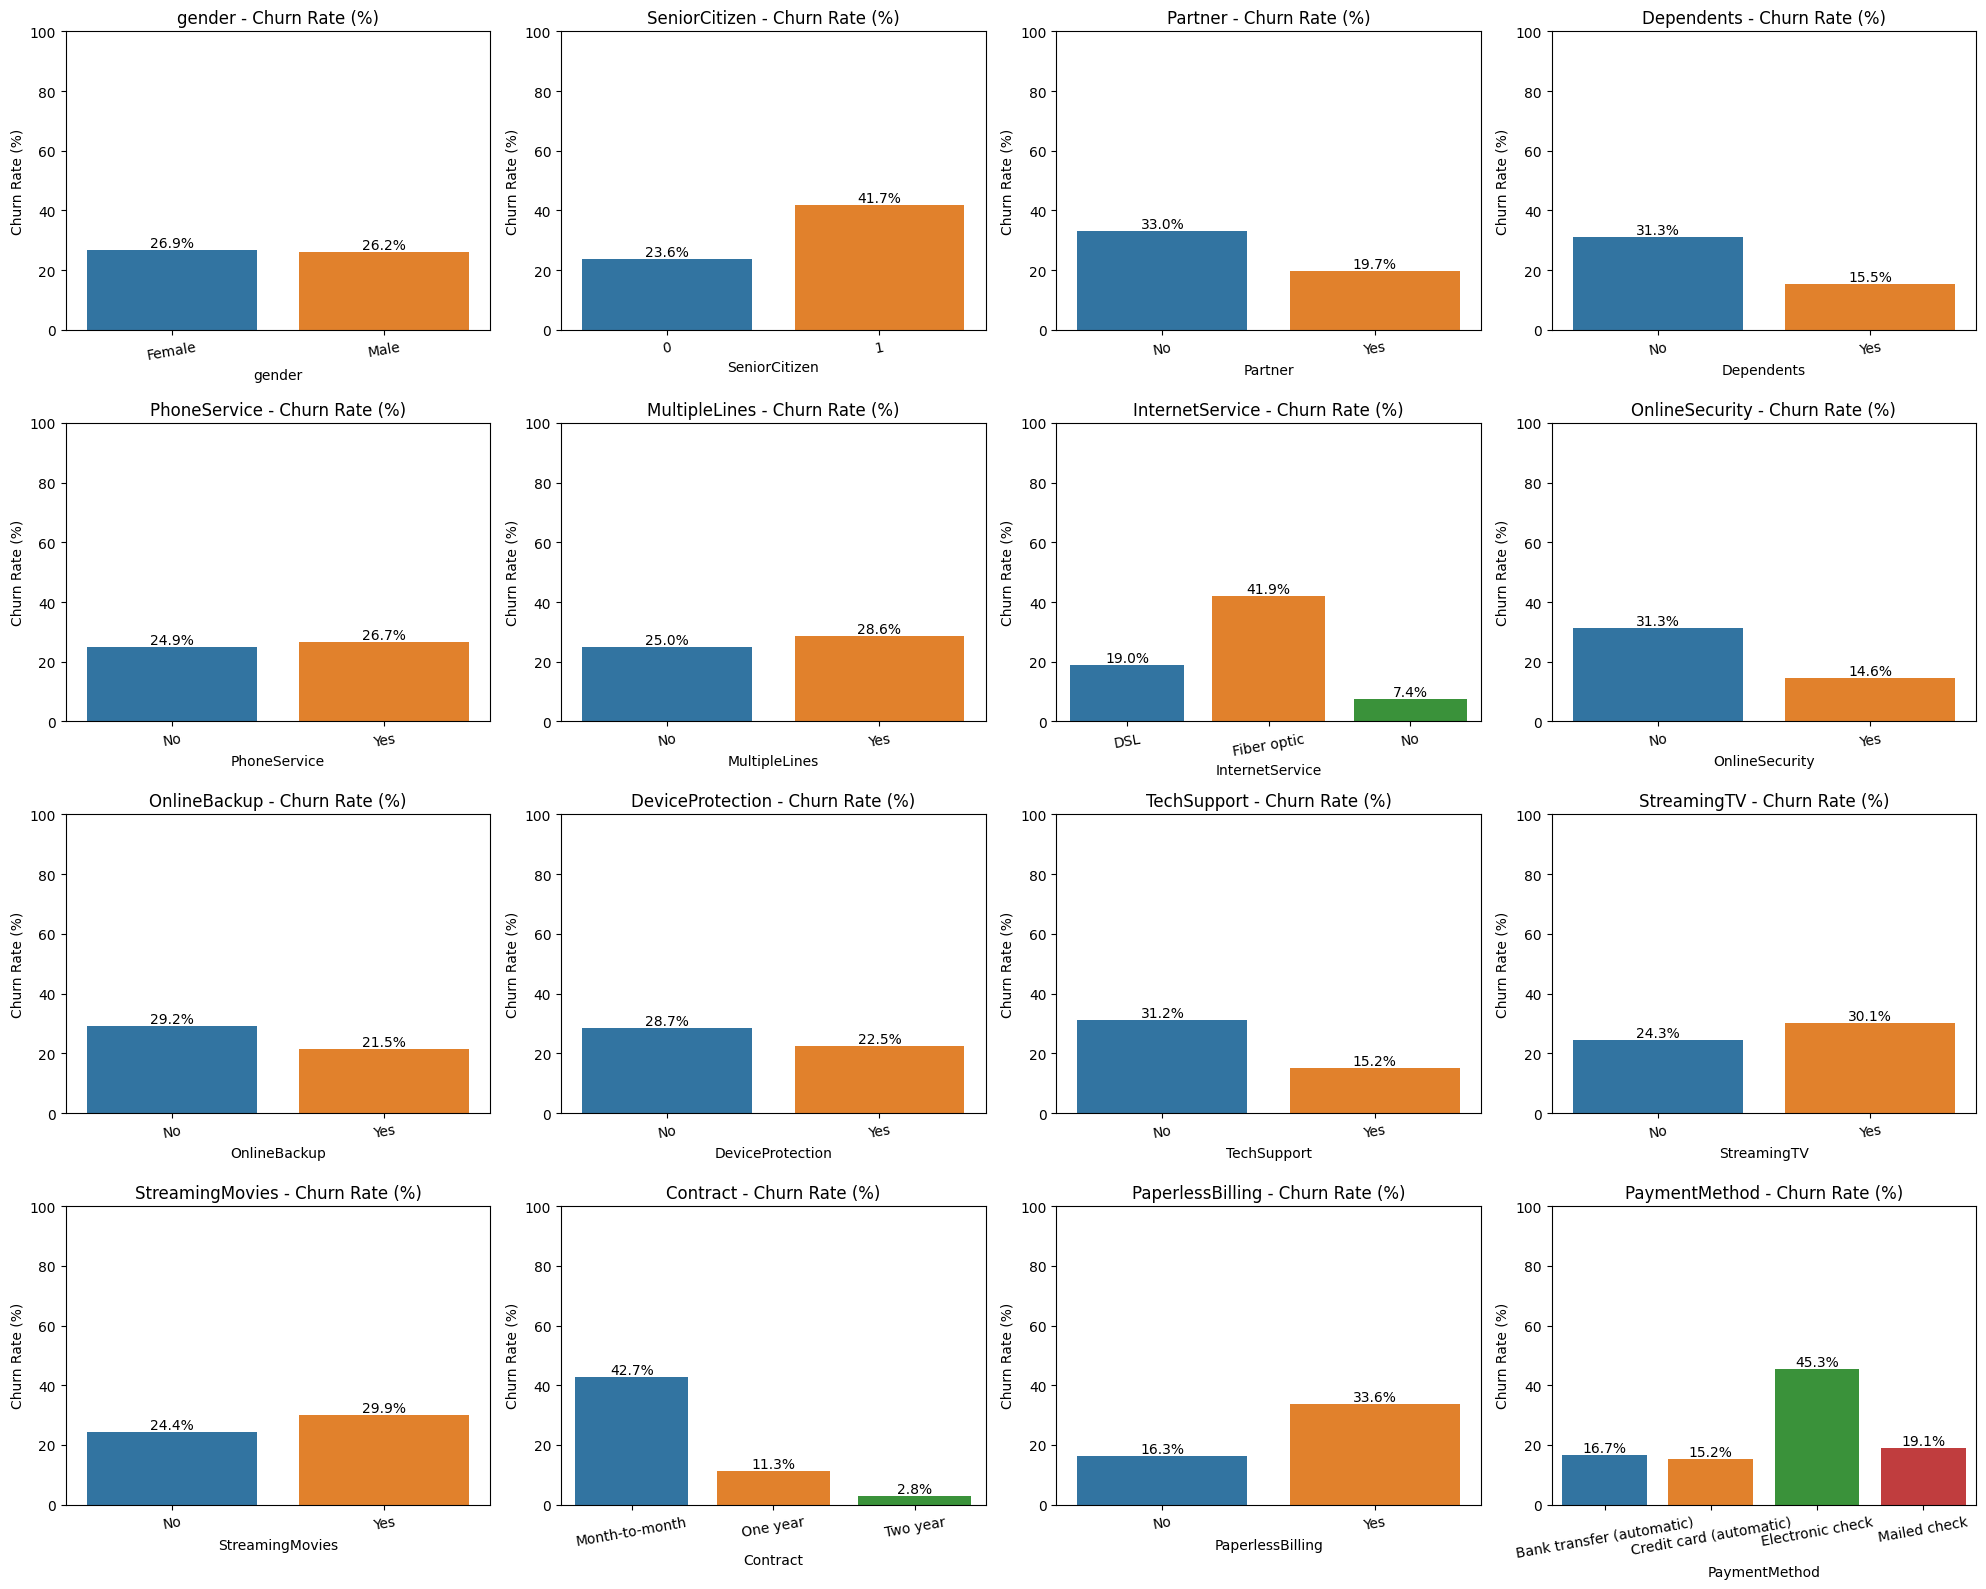

In [ ]:
# The code was referenced by ChatGPT
n_cols = 4
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]

    # Calculate ratio of churn 
    rate_df = (df.groupby(col)["Churn"].mean().reset_index())
    rate_df["Churn"] = rate_df["Churn"] * 100  # %

    # barplot (퍼센트)
    sns.barplot(
        data=rate_df,
        x=col,
        y="Churn",
        ax=ax
    )

    ax.set_title(f"{col} - Churn Rate (%)")
    ax.set_ylabel("Churn Rate (%)")
    ax.set_ylim(0, 100)
    axes[i].tick_params(axis='x', rotation=10)

    # Show percent
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{p.get_height():.1f}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

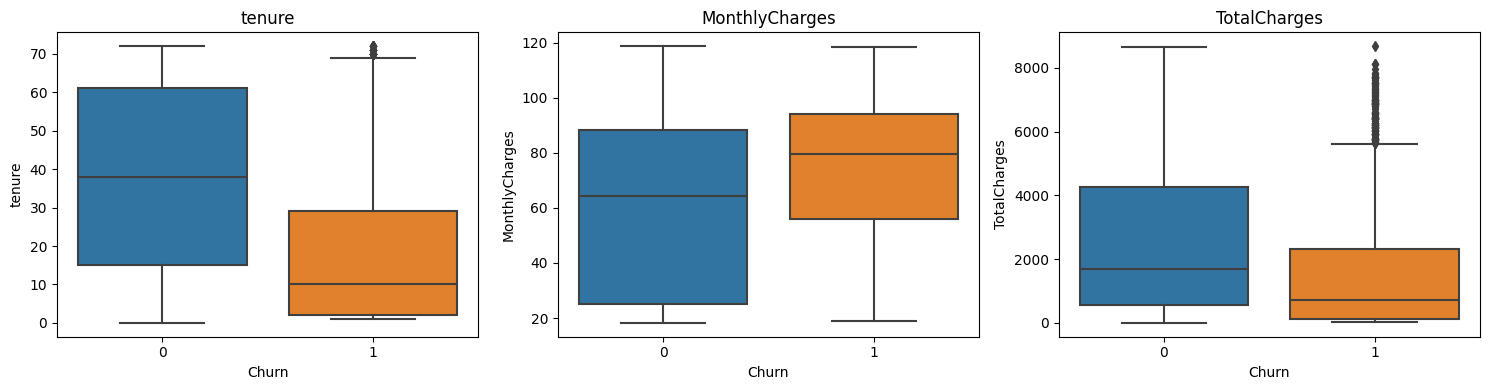

In [422]:
# Check the outlier of numeric values 
n_cols = 3  
n_rows = math.ceil(len(num_cols[:-1]) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols[:-1]):
    sns.boxplot(data=df, x="Churn", y=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

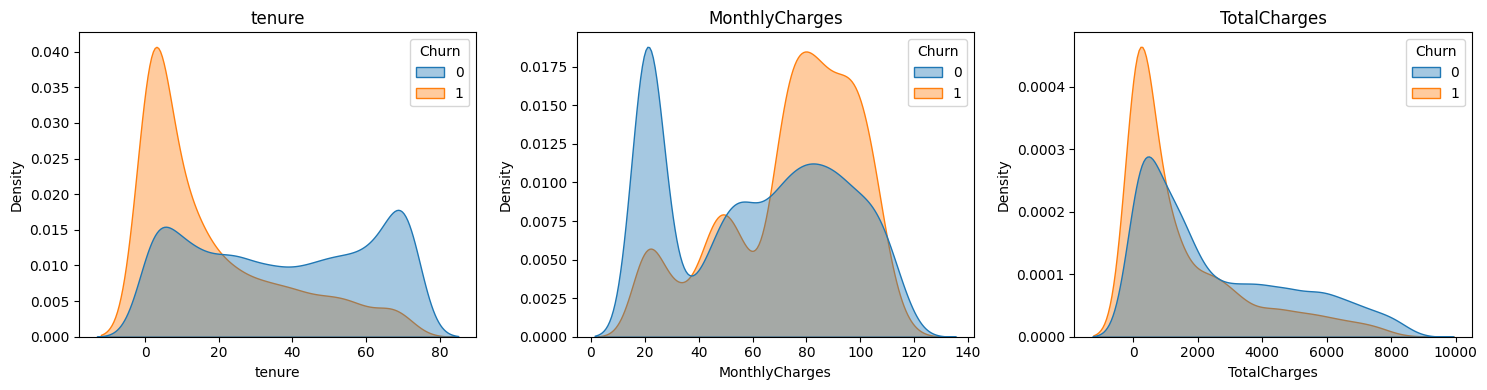

In [423]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols[:-1]):
    sns.kdeplot(data=df, hue="Churn", x=col, fill=True, common_norm=False, alpha=0.4, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## 4. feature engineering

In [153]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# Make 'ChurnRisk' columns according to kdeplot
df['ChurnRisk'] = ((df['tenure'] < 24) & (df['MonthlyCharges'] > 60 )).astype(int)

In [ ]:
# Payment method is changed to 'Is_Electronic_Check'
df['Is_Electronic_Check'] = (df['PaymentMethod'] == 'Electronic check').astype(int)
df.drop(columns = 'PaymentMethod', inplace = True)

In [159]:
# Columns for Label Encoding (binary columns)
binary_cols =  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', \
                'MultipleLines', 'OnlineSecurity', 'OnlineBackup', \
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

for col in binary_cols:
    df[col] = (df[col] == 'Yes').astype(int)

In [ ]:
# one-hot encoding

cat_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
df_encoded.info()

In [ ]:
# Basic model 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

X = df_encoded.drop(columns=['Churn']) 
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000
    ))
])

pipe_lr.fit(X_train, y_train)


pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
y_prob = pipe_lr.predict_proba(X_test)[:, 1]

print("--- Logistic regression Outcomes ---")
print(classification_report(y_test, y_pred))

--- Logistic regression Outcomes ---
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [166]:
len(df_encoded.columns)

23

## 5. Feature selection

In [167]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'Churn' is the target variable and df1_tenure is your preprocessed DataFrame
X = df_encoded.drop(columns=['Churn']) 
y = df_encoded['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (important for Lasso, which is sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Lasso model (alpha controls the regularization strength)
lasso = Lasso(alpha=0.01)

# Fit the Lasso model to the training data
lasso.fit(X_train_scaled, y_train)

# Get the coefficients of the features
lasso_coefficients = lasso.coef_

# Create a DataFrame to display the feature names and their Lasso coefficients
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Lasso_Coefficient': lasso_coefficients})

# Sort the DataFrame by coefficient magnitude in descending order
feature_scores_df = feature_scores_df.reindex(feature_scores_df['Lasso_Coefficient'].abs().sort_values(ascending=False).index)

# Print all feature coefficients
print("All Feature Coefficients:")
print(feature_scores_df)

# Select the features with non-zero coefficients
selected_features = feature_scores_df[feature_scores_df['Lasso_Coefficient'] != 0]['Feature'].tolist()

# Print the selected features
print("\nSelected features:", selected_features)
print("\nNumber of selected features:", len(selected_features))

All Feature Coefficients:
                        Feature  Lasso_Coefficient
4                        tenure          -0.077080
18  InternetService_Fiber optic           0.058637
19           InternetService_No          -0.043141
17          Is_Electronic_Check           0.038058
20            Contract_One year          -0.036426
21            Contract_Two year          -0.035537
16                    ChurnRisk           0.029287
7                OnlineSecurity          -0.026896
13             PaperlessBilling           0.017706
10                  TechSupport          -0.017094
12              StreamingMovies           0.013226
15                 TotalCharges          -0.008254
3                    Dependents          -0.005342
8                  OnlineBackup          -0.004725
6                 MultipleLines           0.004109
5                  PhoneService          -0.002528
0                        gender           0.000000
14               MonthlyCharges           0.000000
1    

In [ ]:
# Mutual_Information_Score

# Assuming 'Churn' is the target variable and df1_tenure is your preprocessed DataFrame
X = df_encoded.drop(columns=['Churn']) 
y = df_encoded['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (not strictly necessary for mutual_info_classif)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X_train_scaled, y_train)

# Create a DataFrame to display the feature names and their mutual information scores
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information_Score': mi_scores})

# Sort the DataFrame by score in descending order
feature_scores_df = feature_scores_df.sort_values(by='Mutual_Information_Score', ascending=False)

# Print all feature scores
print("All Feature Mutual Information Scores:")
print(feature_scores_df)

# Select the features with non-zero mutual information scores
selected_features = feature_scores_df[feature_scores_df['Mutual_Information_Score'] > 0]['Feature'].tolist()

# Print the selected features
print("\nSelected features:", selected_features)
print("\nNumber of selected features:", len(selected_features))

All Feature Mutual Information Scores:
                        Feature  Mutual_Information_Score
16                    ChurnRisk                  0.060693
4                        tenure                  0.057239
21            Contract_Two year                  0.055020
15                 TotalCharges                  0.046233
17          Is_Electronic_Check                  0.044603
14               MonthlyCharges                  0.041581
18  InternetService_Fiber optic                  0.038784
19           InternetService_No                  0.036479
13             PaperlessBilling                  0.025298
3                    Dependents                  0.018272
2                       Partner                  0.014544
20            Contract_One year                  0.011852
10                  TechSupport                  0.010416
11                  StreamingTV                  0.009975
7                OnlineSecurity                  0.006266
1                 SeniorCitizen  

In [ ]:
# Information Gain

# Assuming 'Churn' is the target variable and df1_tenure is your preprocessed DataFrame
X = df_encoded.drop(columns=['Churn']) 
y = df_encoded['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (optional, typically not necessary for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate Information Gain (Mutual Information) for each feature
mutual_info = mutual_info_classif(X_train_scaled, y_train)

# Create a DataFrame to display the feature names and their Information Gain scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': mutual_info})

# Sort the DataFrame by Information Gain in descending order
feature_importance_df = feature_importance_df.sort_values(by='Information Gain', ascending=False)

# Print all feature Information Gain scores
print("Feature Information Gain (Mutual Information):")
print(feature_importance_df)

# Select the top k features (for example, top 10)
num_features_to_select = 10  # Change this to select a different number of features
selected_features = feature_importance_df.head(num_features_to_select)['Feature'].tolist()

# Print the selected features
print("\nSelected features:", selected_features)
print("\nNumber of selected features:", len(selected_features))

Feature Information Gain (Mutual Information):
                        Feature  Information Gain
4                        tenure          0.074029
21            Contract_Two year          0.072303
16                    ChurnRisk          0.052265
18  InternetService_Fiber optic          0.047339
15                 TotalCharges          0.045748
14               MonthlyCharges          0.042828
17          Is_Electronic_Check          0.041200
19           InternetService_No          0.032569
13             PaperlessBilling          0.022773
20            Contract_One year          0.017898
0                        gender          0.015197
10                  TechSupport          0.015185
7                OnlineSecurity          0.011791
12              StreamingMovies          0.010611
3                    Dependents          0.009476
6                 MultipleLines          0.005085
1                 SeniorCitizen          0.002613
2                       Partner          0.002517
9  

In [ ]:
# The final features and dataset
final_features = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'ChurnRisk',
    'Contract_One year',
    'Contract_Two year',
    'InternetService_Fiber optic',
    'InternetService_No',
    'Is_Electronic_Check',
    'PaperlessBilling',
    'OnlineSecurity',
    'TechSupport',
    #'Partner',
    #'Dependents',
    #'SeniorCitizen',
    'Churn'
]

df_encoded1 = df_encoded[final_features]
df_encoded1

tenure  MonthlyCharges  TotalCharges  ChurnRisk  Contract_One year  \
0          1           29.85         29.85          0              False   
1         34           56.95       1889.50          0               True   
2          2           53.85        108.15          0              False   
3         45           42.30       1840.75          0               True   
4          2           70.70        151.65          1              False   
...      ...             ...           ...        ...                ...   
7038      24           84.80       1990.50          0               True   
7039      72          103.20       7362.90          0               True   
7040      11           29.60        346.45          0              False   
7041       4           74.40        306.60          1              False   
7042      66          105.65       6844.50          0              False   

      Contract_Two year  InternetService_Fiber optic  InternetService_No  \
0                 False                        False               False   
1                 False                        False               False   
2                 False                        False               False   
3                 False                        False               False   
4                 False                         True               False   
...                 ...                          ...                 ...   
7038              False                        False               False   
7039              False                         True               False   
7040              False                        False               False   
7041              False                         True               False   
7042               True                         True               False   

      Is_Electronic_Check  PaperlessBilling  OnlineSecurity  TechSupport  \
0                       1                 1               0            0   
1                       0                 0               1            0   
2                       0                 1               1            0   
3                       0                 0               1            1   
4                       1                 1               0            0   
...                   ...               ...             ...          ...   
7038                    0                 1               1            1   
7039                    0                 1               0            0   
7040                    1                 1               1            0   
7041                    0                 1               0            0   
7042                    0                 1               1            1   

      Churn  
0         0  
1         0  
2         1  
3         0  
4         1  
...     ...  
7038      0  
7039      0  
7040      0  
7041      1  
7042      0  

[7043 rows x 13 columns]

## 6. Modeling

### 6-1. Logistic Regression

In [ ]:
X = df_encoded1.drop(columns=['Churn'])
y = df_encoded1['Churn']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline with SMOTE
pipe_lr_smote = Pipeline([
    #('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000
    ))
])

pipe_lr_smote.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [404]:
# Train prediction
y_train_pred = pipe_lr_smote.predict(X_train)

print("TRAIN confusion matrix")
print(confusion_matrix(y_train, y_train_pred))

print("\nTRAIN classification report")
print(classification_report(y_train, y_train_pred))

TRAIN confusion matrix
[[3127 1012]
 [ 403 1092]]

TRAIN classification report
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      4139
           1       0.52      0.73      0.61      1495

    accuracy                           0.75      5634
   macro avg       0.70      0.74      0.71      5634
weighted avg       0.79      0.75      0.76      5634



In [405]:
y_pred = pipe_lr_smote.predict(X_test)
y_prob = pipe_lr_smote.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred) )
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

[[779 256]
 [ 98 276]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409

ROC-AUC Score: 0.8248


### 6-2. Random forest

In [ ]:
# Separate features and target
X = df_encoded1.drop('Churn', axis=1)
y = df_encoded1['Churn']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42 ))])

param_grid = {
    'rf__n_estimators': [10, 20, 100, 200, 300], 
    'rf__max_depth': [3, 4, 6, 8, 10]}
    # SMOTE + RF + bootstrap + 너무 깊은 tree = 위험 : smote 는 synthtic minorty를 강조하기에 
    #'rf__bootstrap': [True]} # True로 고정
    
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=pipe,

    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

grid_search_rf.best_params_, 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


({'rf__max_depth': 4, 'rf__n_estimators': 200},)

In [ ]:
best_model_rf = grid_search_rf.best_estimator_

# Train prediction
y_train_pred = best_model_rf.predict(X_train)

print("TRAIN confusion matrix")
print(confusion_matrix(y_train, y_train_pred))

print("\nTRAIN classification report")
print(classification_report(y_train, y_train_pred))

TRAIN confusion matrix
[[2735  887]
 [ 303 1005]]

TRAIN classification report
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      3622
           1       0.53      0.77      0.63      1308

    accuracy                           0.76      4930
   macro avg       0.72      0.76      0.72      4930
weighted avg       0.80      0.76      0.77      4930



In [363]:
# Test prediction
y_pred = best_model_rf.predict(X_test) 
y_prob = best_model_rf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred) )
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

[[1175  377]
 [ 131  430]]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1552
           1       0.53      0.77      0.63       561

    accuracy                           0.76      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.76      0.77      2113

ROC-AUC Score: 0.8397


### 6-3. Gradient Boosting

In [ ]:
# Separate features and target
X = df_encoded1.drop('Churn', axis=1)
y = df_encoded1['Churn']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# class_weights = {
#     0: len(y_train) / (2 * (y_train == 0).sum()),
#     1: len(y_train) / (2 * (y_train == 1).sum())
# }
# sample_weight = np.array([class_weights[y] for y in y_train])

pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))])

param_grid = {
    'gb__n_estimators': [100, 200, 300], #100, 200, 300]  # 처음에 50, 100, 200 과적합 so 늘림
    'gb__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]}
    #'gb__subsample': [0.7, 0.8, 0.9] # The dataset is not enough large, so didn't used it / regularisation 과다 (이미 변수 많이 죽이고 옴)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_gb = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train, ) #gb__sample_weight=sample_weight

grid_search_gb.best_params_, 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


({'gb__learning_rate': 0.005, 'gb__n_estimators': 300},)

In [396]:
results_gb = pd.DataFrame(grid_search_gb.cv_results_)

results_gb[["params", "mean_test_score", "std_test_score", "rank_test_score"]].sort_values("rank_test_score").head(10)

params  mean_test_score  \
5   {'gb__learning_rate': 0.005, 'gb__n_estimators...         0.626908   
10  {'gb__learning_rate': 0.05, 'gb__n_estimators'...         0.625872   
4   {'gb__learning_rate': 0.005, 'gb__n_estimators...         0.625619   
6   {'gb__learning_rate': 0.01, 'gb__n_estimators'...         0.625087   
11  {'gb__learning_rate': 0.05, 'gb__n_estimators'...         0.623628   
7   {'gb__learning_rate': 0.01, 'gb__n_estimators'...         0.623431   
12  {'gb__learning_rate': 0.1, 'gb__n_estimators':...         0.623017   
9   {'gb__learning_rate': 0.05, 'gb__n_estimators'...         0.621615   
8   {'gb__learning_rate': 0.01, 'gb__n_estimators'...         0.621234   
13  {'gb__learning_rate': 0.1, 'gb__n_estimators':...         0.620871   

    std_test_score  rank_test_score  
5         0.024638                1  
10        0.018813                2  
4         0.023393                3  
6         0.023968                4  
11        0.017517                5  
7         0.024654                6  
12        0.022243                7  
9         0.023249                8  
8         0.026337                9  
13        0.021104               10

In [ ]:
best_model_gb = grid_search_gb.best_estimator_

# Train prediction
y_train_pred = best_model_gb.predict(X_train)

print("TRAIN confusion matrix")
print(confusion_matrix(y_train, y_train_pred))

print("\nTRAIN classification report")
print(classification_report(y_train, y_train_pred))

TRAIN confusion matrix
[[2602 1020]
 [ 226 1082]]

TRAIN classification report
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3622
           1       0.51      0.83      0.63      1308

    accuracy                           0.75      4930
   macro avg       0.72      0.77      0.72      4930
weighted avg       0.81      0.75      0.76      4930



In [398]:
# Test prediction
y_pred = best_model_gb.predict(X_test) 
y_prob = best_model_gb.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

[[1098  454]
 [ 105  456]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1552
           1       0.50      0.81      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113

ROC-AUC Score: 0.8405


### 6-4. LightGMB

In [392]:
# Separate features and target
X = df_encoded1.drop('Churn', axis=1)
y = df_encoded1['Churn']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

pipe = Pipeline([
    #('smote', SMOTE(random_state=42)),
    ('lb', LGBMClassifier(random_state=42, class_weight='balanced'))])

param_grid = {
    'lb__n_estimators': [200, 300, 400], 
    'lb__max_depth': [3, 4, 5, 6, 8, 10],  
    'lb__learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5],
    'lb__num_leaves': [7, 15]} # 트리가 가질 수 있는 최소개수

    
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_lb = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_lb.fit(X_train, y_train)

grid_search_lb.best_params_, 

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1047, number of negative: 2897
[LightGBM] [Info] Number of positive: 1047, number of negative: 2897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of d

({'lb__learning_rate': 0.01,
  'lb__max_depth': 6,
  'lb__n_estimators': 200,
  'lb__num_leaves': 7},)

In [ ]:
best_model_lb = grid_search_lb.best_estimator_
# Train prediction
y_train_pred = best_model_lb.predict(X_train)

print("TRAIN confusion matrix")
print(confusion_matrix(y_train, y_train_pred))

print("\nTRAIN classification report")
print(classification_report(y_train, y_train_pred))

TRAIN confusion matrix
[[2731  891]
 [ 320  988]]

TRAIN classification report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3622
           1       0.53      0.76      0.62      1308

    accuracy                           0.75      4930
   macro avg       0.71      0.75      0.72      4930
weighted avg       0.80      0.75      0.77      4930



In [ ]:
y_pred = best_model_lb.predict(X_test) 
y_prob = best_model_lb.predict_proba(X_test)[:, 1]
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, y_pred) 
print(classification_report(y_test, y_pred))


print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1552
           1       0.53      0.76      0.62       561

    accuracy                           0.76      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.76      0.77      2113

ROC-AUC 점수: 0.8353


### 6-5. XGBoost

In [440]:
# Separate features and target
X = df_encoded1.drop('Churn', axis=1)
y = df_encoded1['Churn']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xb', XGBClassifier(random_state=42))]) #scale_pos_weight=ratio

param_grid = {
    'xb__n_estimators': [100, 200, 300], # 100이하로 내려봐야 소용이 없음 
    'xb__max_depth': [3, 4, 6, 8, 10],  #3까지 내려야 recall이 최대 Increasing this value will make the model more complex and more likely to overfit
    'xb__learning_rate' : [0.05, 0.1, 0.3, 0.5], # 여기는 0.001, 0.005로 내려가는 순간 더 못배움 그래서 더 잘 안나와서 0.01
    'xb__reg_lambda' : [0.1, 0.3, 0.5]} #: alpha 의 경우 큰 효과가 없음
    # subsample :prevent overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xb = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_xb.fit(X_train, y_train)

grid_search_xb.best_params_, 

Fitting 5 folds for each of 180 candidates, totalling 900 fits


({'xb__learning_rate': 0.05,
  'xb__max_depth': 4,
  'xb__n_estimators': 100,
  'xb__reg_lambda': 0.5},)

In [441]:
best_model_xb = grid_search_xb.best_estimator_

# Train prediction
y_train_pred = best_model_xb.predict(X_train)

print("TRAIN confusion matrix")
print(confusion_matrix(y_train, y_train_pred))

print("\nTRAIN classification report")
print(classification_report(y_train, y_train_pred))

TRAIN confusion matrix
[[2805  817]
 [ 321  987]]

TRAIN classification report
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3622
           1       0.55      0.75      0.63      1308

    accuracy                           0.77      4930
   macro avg       0.72      0.76      0.73      4930
weighted avg       0.80      0.77      0.78      4930



In [442]:
y_pred = best_model_xb.predict(X_test) 
y_prob = best_model_xb.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(f"ROC-AUC score: {roc_auc_score(y_test, y_prob):.4f}")

[[1173  379]
 [ 135  426]]
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1552
           1       0.53      0.76      0.62       561

    accuracy                           0.76      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.76      0.77      2113

ROC-AUC score: 0.8353


## 7. Cost-senstivie modeling

In [443]:
# Performance metrics by tenure group (tenure-based segmentation into four groups.
df_error = X_test.copy()

# Acutal value / Predicted value / Predicted probability 
df_error['y_true'] = y_test.values
df_error['y_pred'] = y_pred
df_error['y_prob'] = y_prob

df_error['tenure_bin'] = pd.cut(  
    df_error['tenure'],
    bins=4,
    labels=[0, 1, 2, 3]
)

df_error['error_type'] = np.where((df_error['y_true'] == 1) & (df_error['y_pred'] == 0), 'FN',
    np.where((df_error['y_true'] == 0) & (df_error['y_pred'] == 1), 'FP', 'Correct'))

summary = (
    df_error
    .groupby('tenure_bin')
    .apply(lambda x: pd.Series({
        'count': len(x),
        'accuracy': (x['y_true'] == x['y_pred']).mean(),
        'recall': ((x['y_true'] == 1) & (x['y_pred'] == 1)).sum() / max(1, (x['y_true'] == 1).sum()),
        'precision': ((x['y_true'] == 1) & (x['y_pred'] == 1)).sum()/ max(1, (x['y_pred'] == 1).sum()),
        'avg_prob': x['y_prob'].mean()
    }))
)

summary

count  accuracy    recall  precision  avg_prob
tenure_bin                                                
0           805.0  0.659627  0.862534   0.589319  0.597690
1           419.0  0.737470  0.714286   0.460526  0.382886
2           348.0  0.795977  0.385965   0.379310  0.260715
3           541.0  0.890943  0.400000   0.269231  0.153861

In [444]:
# Evaluate classification performance and business cost at a given threshold.
def eval_threshold_personalized(
    y_true,
    y_prob,
    total_charges,
    t,
    retention_cost=500_000
):
    y_pred = (y_prob >= t).astype(int)

    # Boolean masks
    FN_mask = (y_true == 1) & (y_pred == 0)
    FP_mask = (y_true == 0) & (y_pred == 1)

    # Costs
    cost_fn = total_charges[FN_mask].sum()
    cost_fp = FP_mask.sum() * retention_cost

    total_cost = cost_fn + cost_fp

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)

    return {
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "F1-score" : f1score, 
        "FN_count": FN_mask.sum(),
        "FP_count": FP_mask.sum(),
        "FN_cost": cost_fn,
        "FP_cost": cost_fp,
        "total_cost": total_cost
    }

In [447]:
results = [] 
for t in np.arange(0.4, 0.9, 0.05):
    res = eval_threshold_personalized(
        y_true=y_test.values,
        y_prob=y_prob,
        total_charges=X_test["TotalCharges"].values,
        t=t,
        retention_cost=500_000
    )
    results.append(res)

df_eval = pd.DataFrame(results)
df_eval.sort_values("total_cost") #23,338,160

threshold  precision    recall  F1-score  FN_count  FP_count    FN_cost  \
9       0.85   0.805556  0.206774  0.329078       445        28  767506.75   
8       0.80   0.702899  0.345811  0.463560       367        82  731754.15   
7       0.75   0.644836  0.456328  0.534447       305       141  640752.60   
6       0.70   0.619586  0.586453  0.602564       232       202  483730.05   
5       0.65   0.599665  0.638146  0.618307       203       239  423969.90   
4       0.60   0.581288  0.675579  0.624897       182       273  375446.65   
3       0.55   0.556328  0.713012  0.625000       161       319  351753.10   
2       0.50   0.529193  0.759358  0.623719       135       379  322563.30   
1       0.45   0.513388  0.786096  0.621127       120       418  286515.90   
0       0.40   0.492030  0.825312  0.616511        98       478  239484.20   

     FP_cost    total_cost  
9   14000000  1.476751e+07  
8   41000000  4.173175e+07  
7   70500000  7.114075e+07  
6  101000000  1.014837e+08  
5  119500000  1.199240e+08  
4  136500000  1.368754e+08  
3  159500000  1.598518e+08  
2  189500000  1.898226e+08  
1  209000000  2.092865e+08  
0  239000000  2.392395e+08

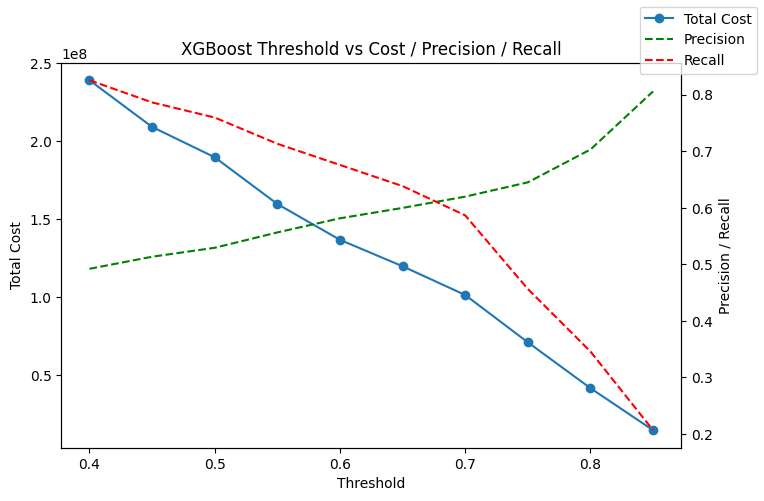

In [448]:
# Cost–performance trade-off across thresholds
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(df_eval["threshold"], df_eval["total_cost"], marker='o', label="Total Cost")
ax1.set_ylabel("Total Cost")
ax1.set_xlabel("Threshold")

ax2 = ax1.twinx()
ax2.plot(df_eval["threshold"], df_eval["precision"], color='green', linestyle='--', label="Precision")
ax2.plot(df_eval["threshold"], df_eval["recall"], color='red', linestyle='--', label="Recall")
ax2.set_ylabel("Precision / Recall")

fig.legend(loc="upper right")
plt.title("XGBoost Threshold vs Cost / Precision / Recall")
plt.show()


- Interpretability

In [451]:
best_pipe = grid_search_xb.best_estimator_

# XGBoost in pipeline
best_xgb = best_pipe.named_steps['xb']

# weight, gain, cover
booster = best_xgb.get_booster()

importance_weight = booster.get_score(importance_type="weight")
importance_gain   = booster.get_score(importance_type="gain")
importance_cover  = booster.get_score(importance_type="cover")

df_importance = pd.DataFrame({
    "feature": importance_gain.keys(),
    "gain": importance_gain.values(),
    "weight": [importance_weight.get(f, 0) for f in importance_gain.keys()],
    "cover": [importance_cover.get(f, 0) for f in importance_gain.keys()]
}).sort_values("gain", ascending=False)

df_importance.head(10)

feature        gain  weight       cover
6   InternetService_Fiber optic  157.847290    61.0  767.487915
5             Contract_Two year   71.348663    59.0  579.594727
10               OnlineSecurity   53.221088    77.0  723.417297
0                        tenure   33.231255   324.0  409.178192
4             Contract_One year   32.379417    68.0  183.058990
11                  TechSupport   26.402966    92.0  533.115479
7            InternetService_No   17.927671     2.0  120.279396
2                  TotalCharges   14.659556   259.0  246.535187
1                MonthlyCharges   12.774264   350.0  342.001923
3                     ChurnRisk   10.338211    14.0  257.668030

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

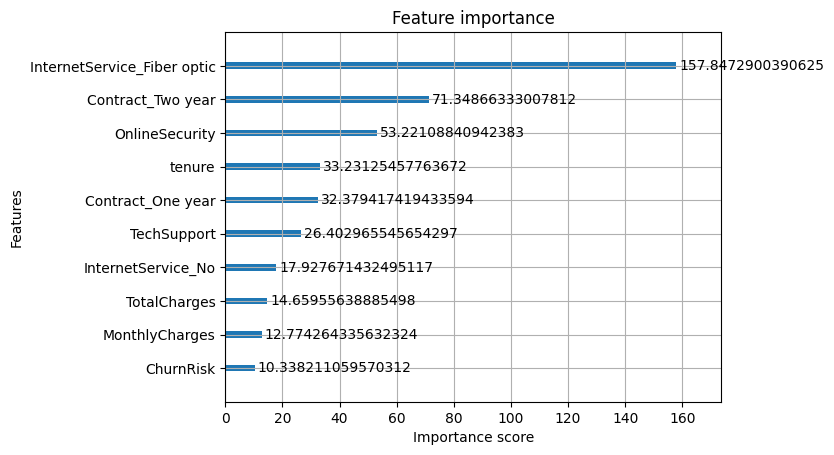

In [454]:
import xgboost as xgb

xgb.plot_importance(best_xgb, importance_type="gain", max_num_features=10)